# Cyber Threat Hunting - Chapter 6

# Scenario

## ACQUIRE AND PREPARE DATA

### Listing 6.7 Jupyter notebook – Collect events a local csv file

- A Import the pandas library into the Python program and aliases it as pd
- B Read a CSV file named ch6_stream_events.csv into pandas DataFrame, df. A The low_memory=False parameter is used to minimize memory usage while reading the file. This is useful for large files or when the data types in the columns are mixed.
- C Print the length of DataFrame df
- D Copy df_original to a new a dataframe, df


In [1]:
import pandas as pd

df_original = pd.read_csv("/Users/nalfarda/Documents/Work/SA/Books/Hunting Book/Proposal/Manning/Book Writing/Chapter 6/Data/output.csv", low_memory=False)
print(len(df_original))
df = df_original

667827


#### Listing 6.8 Jupyter notebook code – Filter events based on a count threshold

- A Set the value of variable count_threshold to 100
- B Keep events that share the same src_ip, dest_ip, and dest_port if the total count > count_threshold
- C reset_index() takes the current index, and places it in column 'index'. Then it recreates a new 'linear' index for the dataset
- D Print the number of rows in DataFrame df


In [2]:
count_threshold = 100
df = df.groupby(['src_ip', 'dest_ip', 'dest_port']).filter \
    (lambda x : len(x)>count_threshold)
df = df.reset_index()
print(len(df.index), "records with count >", count_threshold)

511346 records with count > 100


#### Listing 6.9 Jupyter notebook – Data type of each column

In [3]:
df.dtypes

index               int64
Unnamed: 0          int64
sourcetype         object
endtime            object
timestamp          object
                   ...   
uri_parm           object
message_type       object
query              object
query_type         object
transaction_id    float64
Length: 79, dtype: object

#### Listing 6.11 Jupyter notebook code – Calculate the epoch of timestamp and endtime
- A Convert the timestamp column to datetime object, accommodating mixed formats.
- B Convert the endtime column to datetime object, accommodating mixed formats.
- C Transform timestamp object to epoch timestamps (seconds since Jan 1, 1970) and store it in new columns epoch_timestamp.
- D Transform endtime object to epoch timestamps (seconds since Jan 1, 1970) and store it in new column epoch_endtime.

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed')
df['endtime'] = pd.to_datetime(df['endtime'], format='mixed')
df['epoch_timestamp'] = df['timestamp'].astype('int64') // 10**9
df['epoch_endtime'] = df['endtime'].astype('int64') // 10**9

Check the data/time to epoch conversion

In [5]:
df[['timestamp', 'epoch_timestamp', 'endtime', 'epoch_endtime']]

,timestamp,epoch_timestamp,endtime,epoch_endtime
0,2022-07-27 14:46:54.346452+00:00,1658933214,2022-07-27 14:46:54.346488+00:00,1658933214
1,2022-07-27 14:46:53.839881+00:00,1658933213,2022-07-27 14:46:53.839898+00:00,1658933213
2,2022-07-27 14:46:53.332432+00:00,1658933213,2022-07-27 14:46:53.332470+00:00,1658933213
3,2022-07-27 14:46:52.595835+00:00,1658933212,2022-07-27 14:46:53.566740+00:00,1658933213
4,2022-07-27 14:46:52.682650+00:00,1658933212,2022-07-27 14:46:53.565587+00:00,1658933213
...,...,...,...,...
511341,2022-07-27 14:13:21.350702+00:00,1658931201,2022-07-27 14:13:21.806954+00:00,1658931201
511342,2022-07-27 14:13:21.121610+00:00,1658931201,2022-07-27 14:13:21.124701+00:00,1658931201
511343,2022-07-27 14:13:11.289744+00:00,1658931191,2022-07-27 14:13:11.290784+00:00,1658931191
511344,2022-07-27 14:13:21.122611+00:00,1658931201,2022-07-27 14:13:21.124279+00:00,1658931201


#### Listing 6.12 Jupyter notebook code – Convert columns of type of object to type integer
Convert the fields that contain numeric values to type integer, `int`, so that we can run our calcualtions later.

- A Convert the values in the column epoch_timestamp of the DataFrame df df integers.
- B Convert the values in the column epoch_endtime of the DataFrame df to integers.
- C Convert the values in the column bytes of the DataFrame df to integers.
- D Convert the values in the column bytes_in of the DataFrame df to integers.


In [6]:
df = df.sort_values(by=['epoch_timestamp'], ascending=True)
df['epoch_timestamp'] = df['epoch_timestamp'].astype(int)
df['epoch_endtime'] = df['epoch_endtime'].astype(int)
df['bytes'] = df['bytes'].astype(int)
df['bytes_in'] = df['bytes_in'].astype(int)
df.dtypes

index                            int64
Unnamed: 0                       int64
sourcetype                      object
endtime            datetime64[ns, UTC]
timestamp          datetime64[ns, UTC]
                          ...         
query                           object
query_type                      object
transaction_id                 float64
epoch_timestamp                  int64
epoch_endtime                    int64
Length: 81, dtype: object

In [7]:
print(df.head())

       index  Unnamed: 0   sourcetype                          endtime  \
12768  16640       16640   stream:tcp 2022-07-27 00:25:47.758084+00:00   
7274    9503        9503   stream:tcp 2022-07-27 00:19:17.178540+00:00   
7213    9399        9399  stream:http 2022-07-27 00:19:17.236152+00:00   
7276    9507        9507  stream:http 2022-07-27 00:19:17.226262+00:00   
7275    9505        9505   stream:tcp 2022-07-27 00:19:17.521373+00:00   

                             timestamp  bytes     src_ip            src_mac  \
12768 2022-07-27 00:18:42.697892+00:00  66735   10.0.0.9  00:0D:3A:1A:CC:00   
7274  2022-07-27 00:19:16.275980+00:00  83172  10.0.0.11  00:0D:3A:1A:C4:8D   
7213  2022-07-27 00:19:17.226483+00:00   3570  10.0.0.10  00:0D:3A:10:65:C8   
7276  2022-07-27 00:19:17.225196+00:00    821  10.0.0.10  00:0D:3A:10:65:C8   
7275  2022-07-27 00:19:17.360957+00:00    354  10.0.0.10  00:0D:3A:10:65:C8   

       src_port           connection  ...  uri_query  http_user_agent  cookie  \

## PROCESS DATA

#### Listing 6.13 Jupyter notebook code – Calculate the time difference between similar connections

- A Save the time difference between consecutive events in a new field time_diff_sec based on the value epoch_timestamp, which is in seconds. In Python, lambda allows you to define expressions, allowing you to write simple functions with a single expression without defining them with the def keyword. In our case, we are applying an expression that calculates the time difference between the consecutive values of epoch_timestamp. apply() is used with Python lambda to execute the expression. In our case, we apply the expression after grouping by src_ip, dest_ip , and dest_port. The results of applying the expression are stored in a new column, time_diff_sec, in the same DataFrame, df.

In [8]:
df['time_diff_sec'] = df.groupby(['src_ip', 'dest_ip', 'dest_port'])\
    ['epoch_timestamp'].transform(lambda x: x - x.shift(1))

#### Listing 6.14 Jupyter notebook code – Calculate standard deviation, variance and count

- A Calculate the standard deviation for rows that share the same src_ip, dest_ip, and dest_portusing the values in column time_diff_sec and store the results in a new column std1
- B Calculate the variance for rows that share the same src_ip, dest_ip, and dest_port using the values in column time_diff_sec and store the results in a new column var1
- C Count rows that share the same src_ip, dest_ip, and dest_port using the values in column time_diff_sec and store the results in a new column count1


In [9]:
df['std1'] = df.groupby(['src_ip', 'dest_ip', 'dest_port'])\
    ['time_diff_sec'].transform('std')
df['var1'] = df.groupby(['src_ip', 'dest_ip', 'dest_port'])\
    ['time_diff_sec'].transform('var')
df['count1'] = df.groupby(['src_ip', 'dest_ip', 'dest_port'])\
    ['time_diff_sec'].transform('count')
df[['var1','std1']].sort_values(by=['std1'], ascending=True)

,var1,std1
146495,6.451613e-03,0.080322
376303,6.451613e-03,0.080322
162267,6.451613e-03,0.080322
402800,6.451613e-03,0.080322
137725,6.451613e-03,0.080322
...,...,...
4332,1.582323e+07,3977.842291
4336,1.582323e+07,3977.842291
4355,1.582323e+07,3977.842291
4372,1.582323e+07,3977.842291


#### Listing 6.15 Jupyter notebook code – Display selected columns in the DataFrame df
- A Display few columns in the DataFrame df

In [10]:
df[['src_ip', 'dest_ip', 'dest_port', 'std1', 'var1', 'count1', 'app']]\
    .sort_values(by=['std1'], ascending=True)

,src_ip,dest_ip,dest_port,std1,var1,count1,app
146495,10.0.0.8,52.226.139.185,443,0.080322,6.451613e-03,155,unknown
376303,10.0.0.8,52.226.139.185,443,0.080322,6.451613e-03,155,unknown
162267,10.0.0.8,52.226.139.185,443,0.080322,6.451613e-03,155,unknown
402800,10.0.0.8,52.226.139.185,443,0.080322,6.451613e-03,155,unknown
137725,10.0.0.8,52.226.139.185,443,0.080322,6.451613e-03,155,unknown
...,...,...,...,...,...,...,...
4332,10.0.0.10,108.138.128.47,443,3977.842291,1.582323e+07,107,ssl
4336,10.0.0.10,108.138.128.47,443,3977.842291,1.582323e+07,107,ssl
4355,10.0.0.10,108.138.128.47,443,3977.842291,1.582323e+07,107,ssl
4372,10.0.0.10,108.138.128.47,443,3977.842291,1.582323e+07,107,ssl


#### Listing 6.16 Jupyter notebook code – Drop duplicates
- A Remove the duplicate rows based on src_ip, dest_ip, and dest_port and store the result in a new DataFrame, unique_df
- B Sort unique_df ascending based on the value of std1


In [11]:
unique_df = df.drop_duplicates(['src_ip', 'dest_ip', 'dest_port'])
unique_df[['src_ip', 'dest_ip', 'dest_port', 'std1', 'var1',\
    'count1', 'app']].sort_values(by=['std1'], ascending=True)

,src_ip,dest_ip,dest_port,std1,var1,count1,app
65430,10.0.0.8,52.226.139.185,443,0.080322,6.451613e-03,155,ssl
4782,10.0.0.7,52.226.139.121,443,0.094701,8.968244e-03,222,unknown
10220,10.0.0.6,52.226.139.185,443,0.277019,7.673964e-02,222,unknown
4577,10.0.0.12,52.226.139.121,443,0.286851,8.228333e-02,170,unknown
7051,10.0.0.12,44.238.73.15,9997,0.309736,9.593646e-02,1378,unknown
...,...,...,...,...,...,...,...
32756,10.0.0.7,173.222.170.99,80,2627.209391,6.902229e+06,115,NaN
24175,10.0.0.4,173.222.170.99,80,2871.318325,8.244469e+06,105,ebay
94899,10.0.0.11,192.111.4.10,443,3342.416695,1.117175e+07,168,ssl
87408,10.0.0.10,108.138.128.122,443,3663.833032,1.342367e+07,104,ssl


### IDENTIFY BEACONING

#### Listing 6.15 Jupyter notebook code – Keep rows with low standard deviation values

- A Set the value of a new variable, std_threshold to 100
- B Look for rows with std1 < std_threshold and update unique_df accordingly
- C Display the value of specific columns after sorting unique_df in ascending order based on the value of std1


In [12]:
std_threshold = 100
unique_df = unique_df.loc[unique_df['std1'] <  \
    std_threshold].sort_values(by=['dest_ip'], ascending=True)
unique_df[['src_ip', 'dest_ip', 'dest_port', \
    'std1', 'var1', 'count1',  'app']].sort_values(by=['std1'], ascending=True)

,src_ip,dest_ip,dest_port,std1,var1,count1,app
65430,10.0.0.8,52.226.139.185,443,0.080322,0.006452,155,ssl
4782,10.0.0.7,52.226.139.121,443,0.094701,0.008968,222,unknown
10220,10.0.0.6,52.226.139.185,443,0.277019,0.076740,222,unknown
4577,10.0.0.12,52.226.139.121,443,0.286851,0.082283,170,unknown
7051,10.0.0.12,44.238.73.15,9997,0.309736,0.095936,1378,unknown
...,...,...,...,...,...,...,...
6469,10.0.0.12,169.254.169.254,80,90.116138,8120.918315,459,windows_azure
9027,10.0.0.9,169.254.169.254,80,90.371816,8167.065044,129,windows_azure
26766,10.0.0.12,208.80.154.224,443,92.376621,8533.440114,2567,wikipedia
8544,10.0.0.4,208.80.154.224,443,97.746365,9554.351840,3293,wikipedia


#### Listing 6.16 Jupyter notebook code – Summarize the unique destination IP addresses
- A Drop duplicate records based on dest_ip and update unique_df accordingly
- B Display the rows of unique_df sorted in ascending order based on dest_ip

In [13]:
unique_df = unique_df.loc[unique_df['std1'] < \
    std_threshold].drop_duplicates(['dest_ip'])
unique_df[['dest_ip']].sort_values(by=['dest_ip'], \
    ascending=True)


,dest_ip
495078,10.0.0.10
7243,10.0.0.11
222037,10.0.0.12
7252,10.0.0.4
7262,10.0.0.6
7268,10.0.0.7
7267,10.0.0.8
7263,10.0.0.9
7208,168.63.129.16
8697,169.254.169.254


## BEACONING TO 208.80.154.224

### Listing 6.19 Jupyter notebook code – IP addresses communicating with 208.80.154.224
- A Search for events with field dest_ip set to 208.80.154.224. Group and count the output of the previous command based on the src_ip, dest_ip, dest_port, app and sourcetype.

In [14]:
#pd.set_option('display.max_rows', 100)
df_original.loc[df_original['dest_ip'] == \
    '208.80.154.224'].groupby(['src_ip',\
    'dest_ip', 'dest_port', 'app', 'sourcetype']).size()

src_ip     dest_ip         dest_port  app        sourcetype
10.0.0.10  208.80.154.224  80         wikipedia  stream:tcp      10
                           443        wikipedia  stream:tcp    3591
10.0.0.11  208.80.154.224  80         wikipedia  stream:tcp       4
                           443        wikipedia  stream:tcp    4128
10.0.0.12  208.80.154.224  443        wikipedia  stream:tcp    2568
10.0.0.4   208.80.154.224  80         wikipedia  stream:tcp      14
                           443        wikipedia  stream:tcp    3294
10.0.0.6   208.80.154.224  80         wikipedia  stream:tcp       4
                           443        wikipedia  stream:tcp    4069
10.0.0.7   208.80.154.224  80         wikipedia  stream:tcp       4
                           443        wikipedia  stream:tcp    3322
10.0.0.8   208.80.154.224  80         wikipedia  stream:tcp       1
                           443        wikipedia  stream:tcp    2633
10.0.0.9   208.80.154.224  443        wikipedia  stream:

In [15]:
#pd.reset_option('display.max_rows')

#### Listing 6.22 Jupyter notebook code – Search for 208.80.154.224 in events
- A Search for events with dest_ip 208.80.154.224

In [16]:
df_original.loc[df_original['dest_ip'] == '208.80.154.224'].\
    groupby(['src_ip', 'site', 'uri_path', 'status']).size()

src_ip     site                   uri_path                                                       status
10.0.0.10  commons.wikimedia.org  /w/api.php                                                     301       1
                                  /w/index.php                                                   301       1
                                  /wiki/%EB%8C%80%EB%AC%B8                                       301       1
                                  /wiki/Cifapad                                                  301       2
                                  /wiki/Commons:Media_help                                       301       1
                                  /wiki/Commons:Media_help/nl                                    301       1
                                  /wiki/Faqja_kryesore                                           301       1
                                  /wiki/File:Gnome-audio-x-generic.svg                           301       1
                        

### Listing 6.23 Jupyter notebook code – Plot the value of time_diff_sec for connections between 10.0.0.4 and 208.80.154.224 over port 443
- A For specific values of src_ip, dest_ip, and dest_port in DataFrame df, sort the output based on date, set date as the index and generate a plot that shows the value of time_diff_sec over time. The plot instruction includes parameters such as the figure size, width of 25 inches and height of 5, the plot type, line, and color, orange. set(xticklabels=[]) instructs the program to plot without displaying the x-axis ticks. You can change the plot settings to match your preference.

[[Text(1658870000.0, 0, ''),
  Text(1658880000.0, 0, ''),
  Text(1658890000.0, 0, ''),
  Text(1658900000.0, 0, ''),
  Text(1658910000.0, 0, ''),
  Text(1658920000.0, 0, ''),
  Text(1658930000.0, 0, ''),
  Text(1658940000.0, 0, '')]]

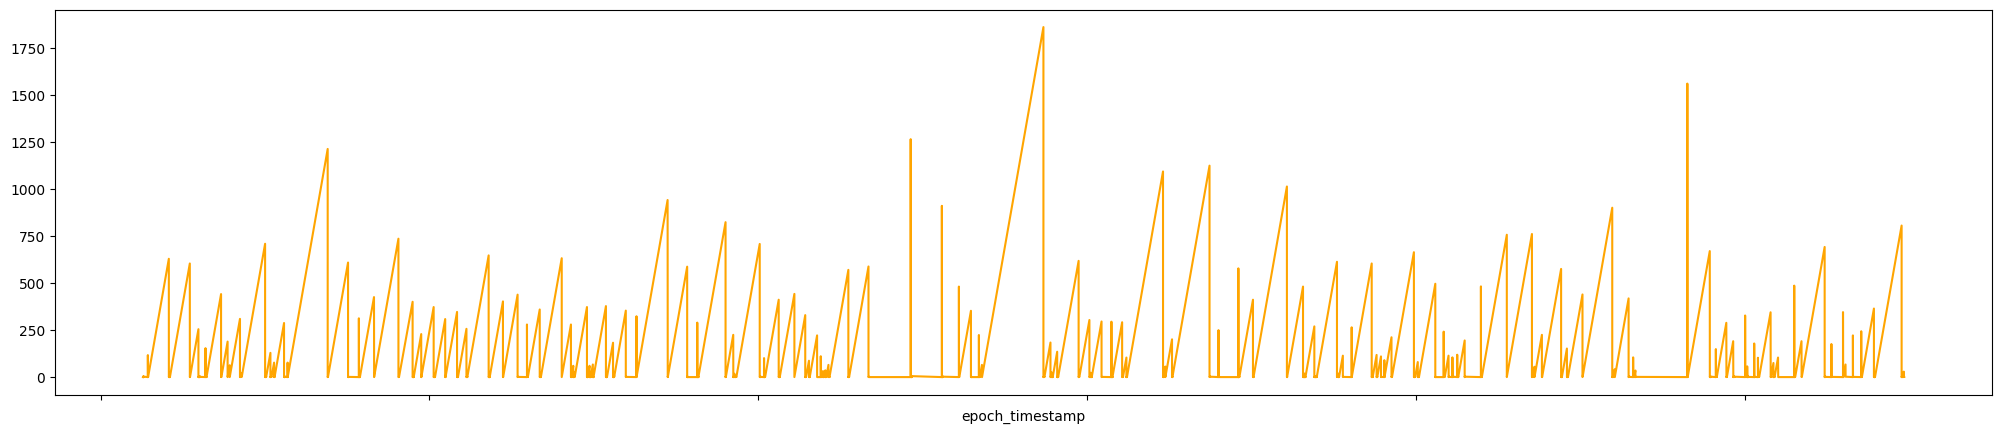

In [17]:
df.loc[(df['src_ip'] == '10.0.0.4') & (df['dest_ip'] == \
    '208.80.154.224') & (df['dest_port'] == 443)].\
        sort_values(by=['epoch_timestamp'], ascending=True).\
            set_index('epoch_timestamp')['time_diff_sec'].\
                plot(figsize=[25,5], kind='line', color='orange')\
                    .set(xticklabels=[])

#### Listing 6.24 Jupyter notebook code – Plot the value of time_diff_sec for connections between 10.0.0.4 and 208.80.154.224 over port 443
- A For specific values of src_ip, dest_ip, and dest_port in DataFrame df, sort the output based on date, set date as the index, and finally generate a histogram type of plot with a width of 25 inches and height of 5 inches.

<Axes: >

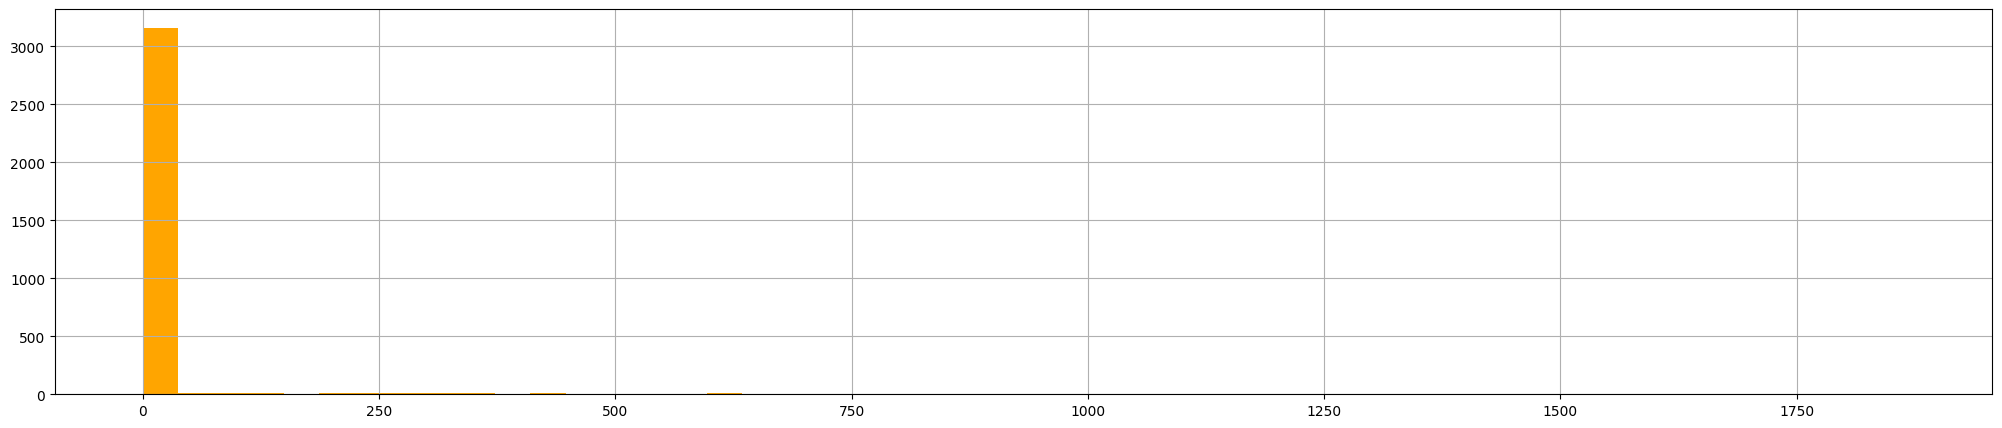

In [18]:
df.loc[(df['src_ip'] == '10.0.0.4') & (df['dest_ip'] \
    == '208.80.154.224') & (df['dest_port'] == 443)].\
        sort_values(by=['epoch_timestamp'], ascending=True).\
            set_index('epoch_timestamp')['time_diff_sec'].\
                hist(figsize=[25,5], color='orange', bins=50)

## BEACONING TO 34.125.188.180

#### Listing 6.25 Jupyter notebook code – IP addresses communicating with 34.125.188.180
- A Search for events with source column dest_ip set to 34.125.188.180, then group and count the output based on the src_ip, dest_ip, dest_port, app, and sourcetype

In [19]:
df_original.loc[df_original['dest_ip'] == \
    '34.125.188.180'].groupby(['src_ip',\
    'dest_ip', 'dest_port', 'app', 'sourcetype']).size()

src_ip    dest_ip         dest_port  app      sourcetype
10.0.0.4  34.125.188.180  80         http     stream:tcp    755
                                     unknown  stream:tcp    770
dtype: int64

#### Listing 6.27 Jupyter notebook code – Search for events with dest_ip 34.125.188.180
- A Filter rows in the df_original DataFrame where the dest_ip column equals 34.125.188.180, group the filtered data by the columns src_ip, site, uri_path, and status, and then count the number of occurrences for each group.

In [20]:
df_original.loc[df_original['dest_ip'] == '34.125.188.180'].\
    groupby(['src_ip', 'site', 'uri_path', 'status']).size()


src_ip    site            uri_path     status
10.0.0.4  34.125.188.180  /b           200         1
                                       404         2
                          /cm          200       677
                          /submit.php  200        73
dtype: int64

#### Listing 6.31 Jupyter notebook code – Search for 34.125.188.180 in events with uri_path set to /submit.php or /cm
- A Filter the df_original DataFrame for entries where the destination IP is 34.125.188.180 and the URI path is either /submit.php or /cm, group the entries by uri_path, http_method, and status, and count the number of occurrences in each group.

In [21]:
df_original.loc[(df_original['dest_ip'] == '34.125.188.180') & \
    ((df_original['uri_path'] == '/submit.php') | \
        (df_original['uri_path'] == '/cm'))].\
            groupby(['uri_path', 'http_method', 'status']).size()


uri_path     http_method  status
/cm          GET          200       677
/submit.php  POST         200        73
dtype: int64

#### Listing 6.33 Jupyter notebook code – Calculate the standard deviation for all values of app
- A Filter the unique_df DataFrame for rows where the source IP is 10.0.0.4, the destination IP is 34.125.188.180, and the destination port is 80. It then groups these filtered entries by the std1 column and counts the occurrences for each unique value in std1.

In [22]:
unique_df.loc[(unique_df['src_ip'] == '10.0.0.4') & \
    (unique_df['dest_ip'] == '34.125.188.180') & \
        (unique_df['dest_port'] == 80)].groupby(unique_df['std1']).size()

std1
28.829445    1
dtype: int64

#### Listing 6.34 Jupyter notebook code – Time difference in seconds between connections over time for all values of app
- A Filter df for rows matching a src_ip 10.0.0.4, dest_ip 34.125.188.180, and dest_port 80, sort them by epoch_timestamp in ascending order, and then plot a line graph of the time_diff_sec values against epoch_timestamp. The x-axis labels are removed to simplify the visualization.

[[Text(1658880000.0, 0, ''),
  Text(1658890000.0, 0, ''),
  Text(1658900000.0, 0, ''),
  Text(1658910000.0, 0, ''),
  Text(1658920000.0, 0, ''),
  Text(1658930000.0, 0, ''),
  Text(1658940000.0, 0, '')]]

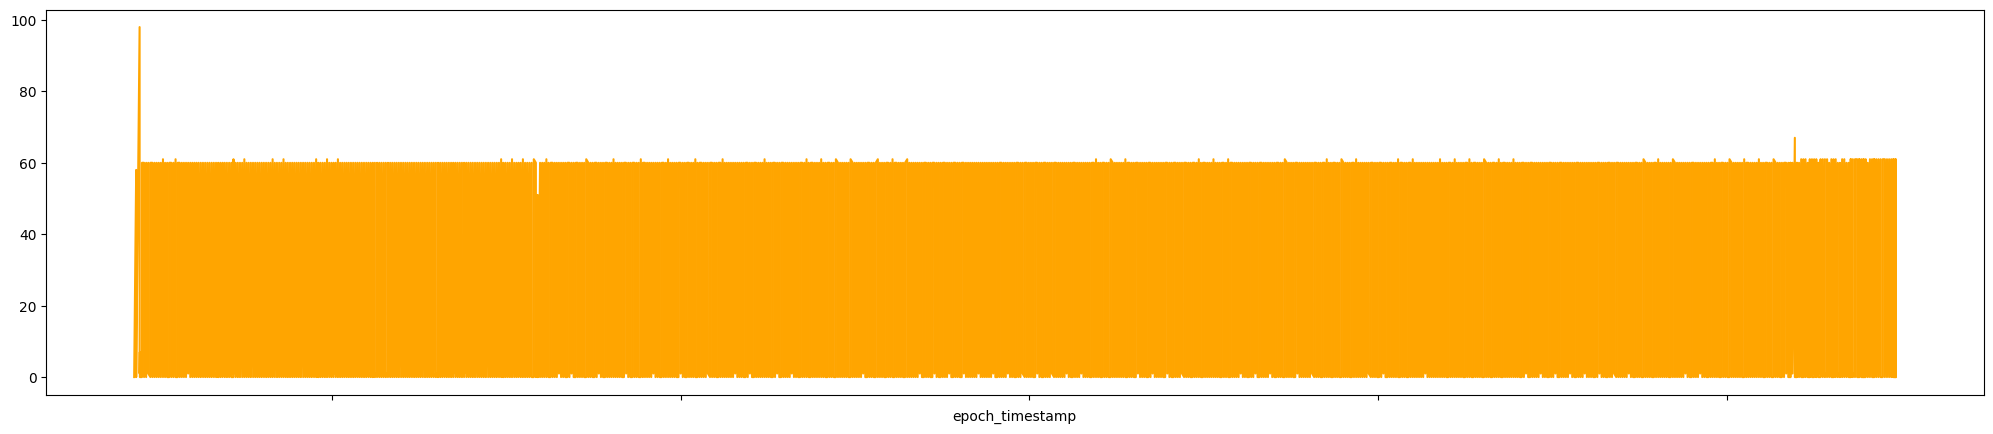

In [23]:
df.loc[(df['src_ip'] == '10.0.0.4') & (df['dest_ip'] == \
    '34.125.188.180') & (df['dest_port'] == 80)].\
        sort_values(by=['epoch_timestamp'], ascending=True).\
            set_index('epoch_timestamp')['time_diff_sec'].\
                plot(figsize=[25,5], kind='line', color='orange')\
                    .set(xticklabels=[])

### Listing 6.35 Jupyter notebook code – Calculate the standard deviation for connections with app set to http

In [24]:
df.loc[(df['src_ip'] == '10.0.0.4') & (df['dest_ip'] == \
    '34.125.188.180')  & (df['dest_port'] == 80) & \
        (df['app'] == 'http')].groupby(['app', 'std1']).size()

app   std1     
http  28.829445    755
dtype: int64

#### Listing 6.36 Jupyter notebook code – Time difference in seconds between connections over time for app set to http

[[Text(1658880000.0, 0, ''),
  Text(1658890000.0, 0, ''),
  Text(1658900000.0, 0, ''),
  Text(1658910000.0, 0, ''),
  Text(1658920000.0, 0, ''),
  Text(1658930000.0, 0, ''),
  Text(1658940000.0, 0, '')]]

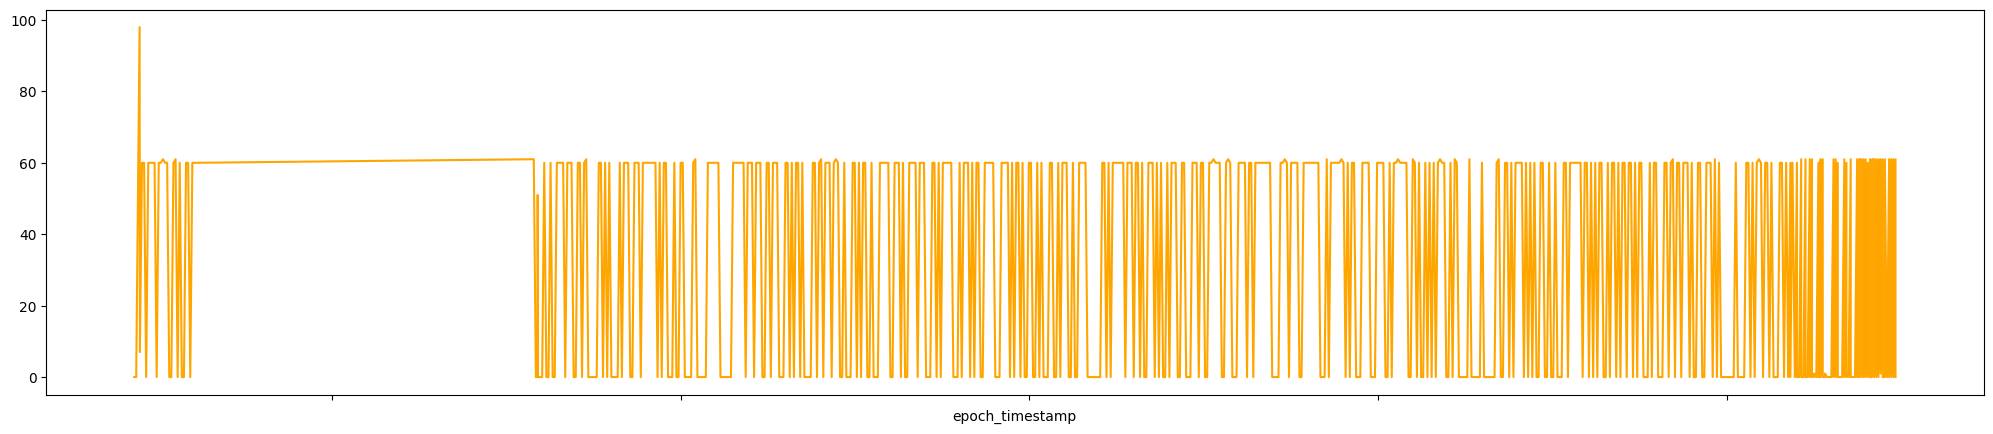

In [26]:
df.loc[(df['src_ip'] == '10.0.0.4') & (df['dest_ip'] == \
    '34.125.188.180') & (df['dest_port'] == 80) & (df['app'] == 'http')].\
        sort_values(by=['epoch_timestamp'], ascending=True).\
            set_index('epoch_timestamp')['time_diff_sec'].\
                plot(figsize=[25,5], kind='line', color='orange')\
                    .set(xticklabels=[])

#### Listing 6.39 Jupyter notebook code – Calculate the standard deviation for connections with app set to http


In [27]:
df.loc[(df['src_ip'] == '10.0.0.4') & (df['dest_ip'] == \
    '34.125.188.180')  & (df['dest_port'] == 80) & \
        (df['app'] == 'unknown')].groupby(['app', 'std1']).size()

app      std1     
unknown  28.829445    770
dtype: int64

#### Listing 6.40 Jupyter notebook code – Calculating standard deviation for app set to unknown

[[Text(1658884000.0, 0, ''),
  Text(1658886000.0, 0, ''),
  Text(1658888000.0, 0, ''),
  Text(1658890000.0, 0, ''),
  Text(1658892000.0, 0, ''),
  Text(1658894000.0, 0, ''),
  Text(1658896000.0, 0, ''),
  Text(1658898000.0, 0, '')]]

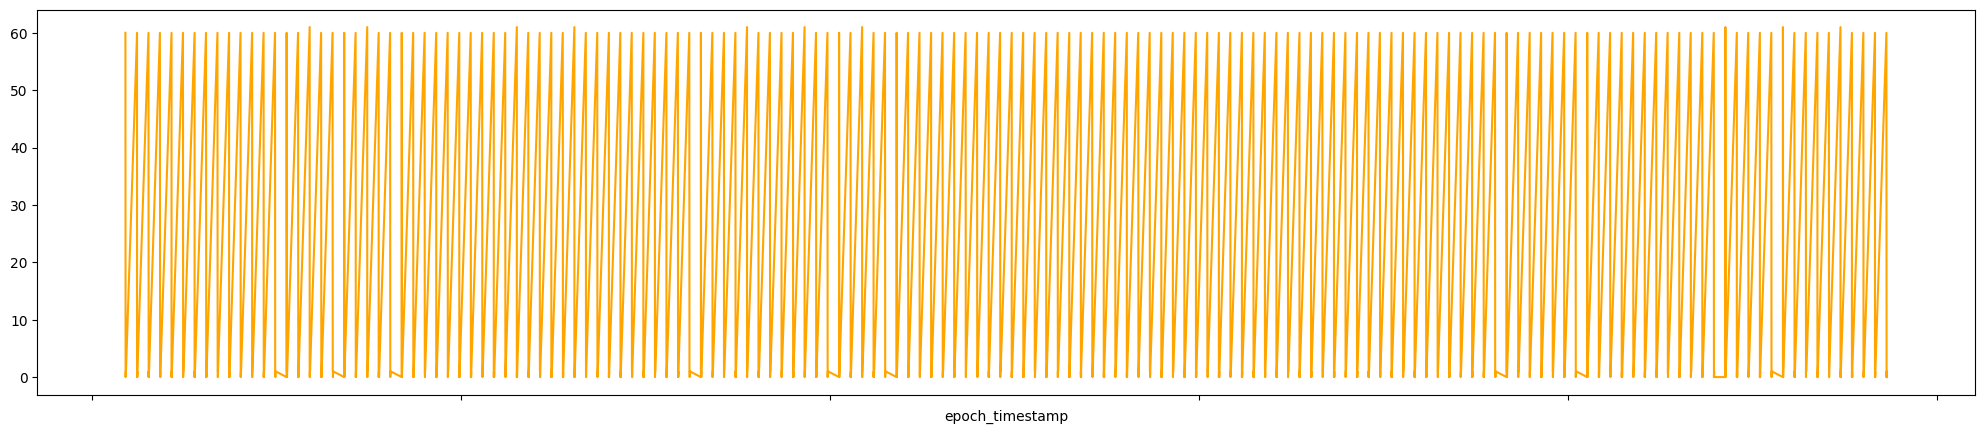

In [29]:
df.loc[(df['src_ip'] == '10.0.0.4') & (df['dest_ip'] == \
    '34.125.188.180') & (df['dest_port'] == 80) & (df['app'] == 'unknown')].\
        sort_values(by=['epoch_timestamp'], ascending=True).\
            set_index('epoch_timestamp')['time_diff_sec'].\
                plot(figsize=[25,5], kind='line', color='orange')\
                    .set(xticklabels=[])

#### Listing 6.41 Jupyter notebook code – Generate a histogram showing the distribution of time_diff_sec for app set to http

<Axes: >

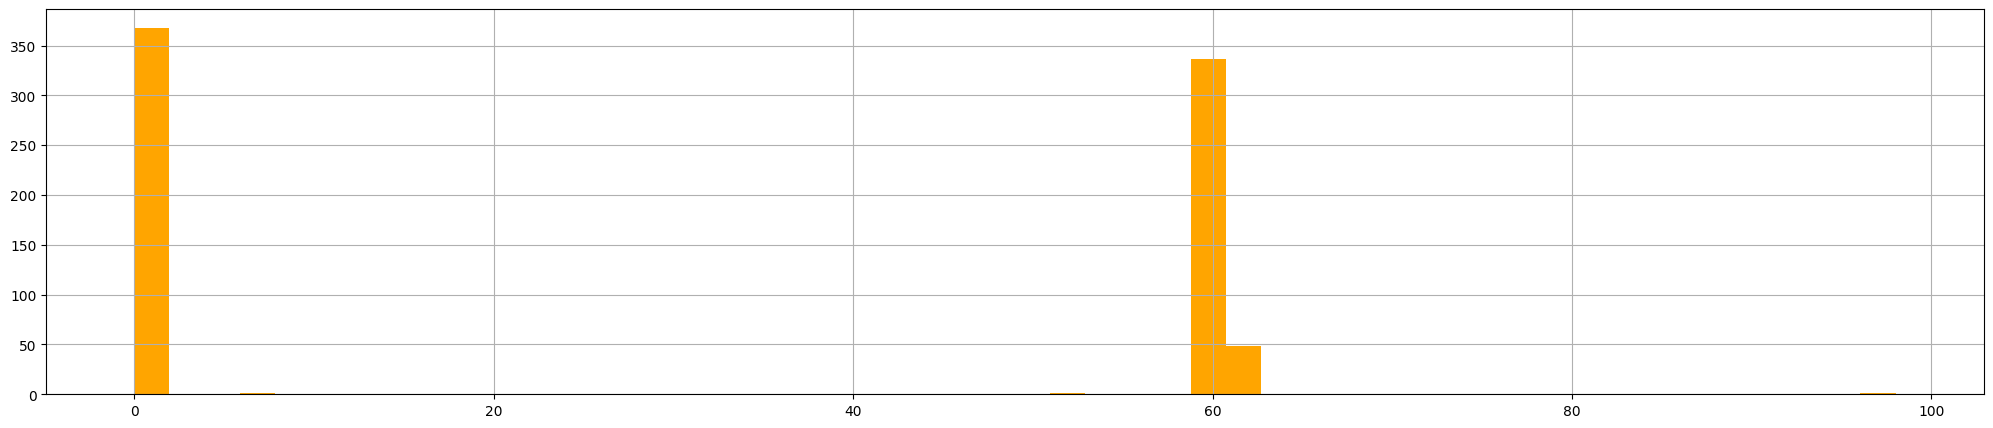

In [30]:
df.loc[(df['src_ip'] == '10.0.0.4') & (df['dest_ip'] \
    == '34.125.188.180') & (df['dest_port'] == 80) & \
        (df['app'] == 'http')].sort_values(by=['epoch_timestamp'], \
            ascending=True).set_index('epoch_timestamp')['time_diff_sec'].\
                hist(figsize=[25,5], color='orange',  bins=50)

#### Listing 6.42 Jupyter notebook code – Generate a histogram showing the distribution of time_diff_sec for app set to unknown

<Axes: >

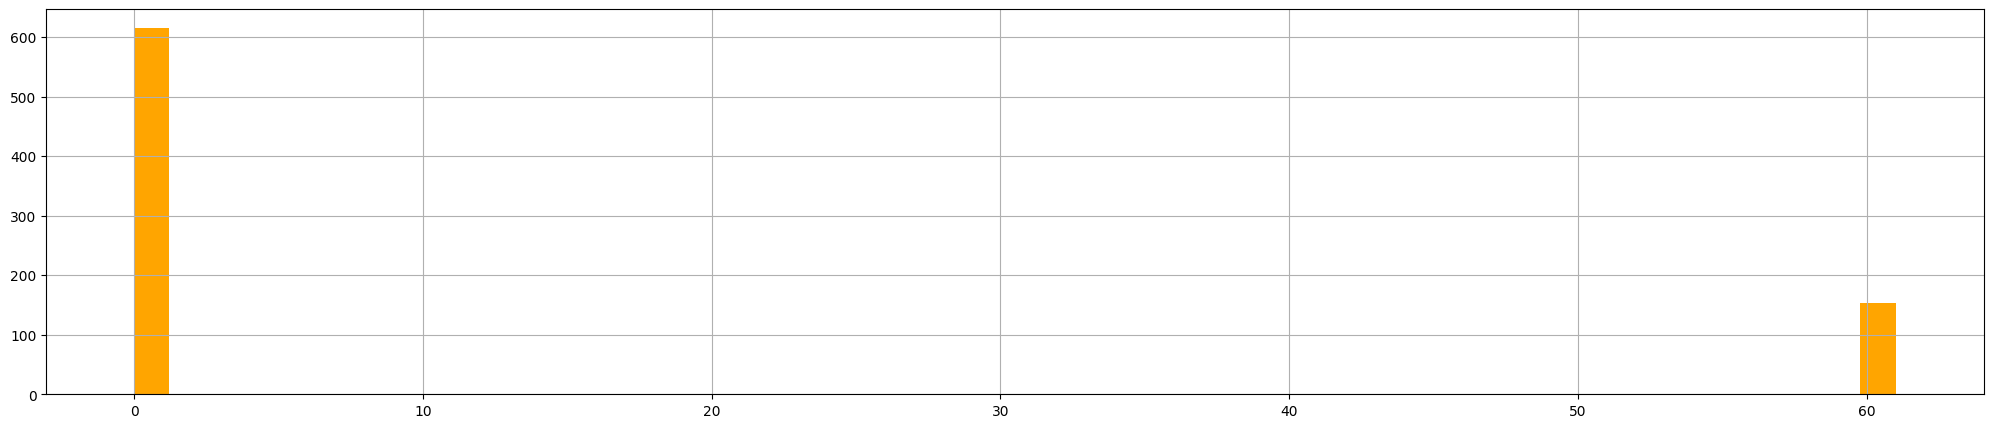

In [31]:
df.loc[(df['src_ip'] == '10.0.0.4') & (df['dest_ip'] \
    == '34.125.188.180') & (df['dest_port'] == 80) & \
        (df['app'] == 'unknown')].sort_values(by=['epoch_timestamp'], \
            ascending=True).set_index('epoch_timestamp')['time_diff_sec'].\
                hist(figsize=[25,5], color='orange', bins=50)

# Answers to Exercise

#### Listing 6.45 Jupyter notebook code – Number of connections between 10.0.0.6 and 208.80.154.224

In [36]:
df_original[(df_original['src_ip'] == '10.0.0.6') & \
    (df_original['dest_ip'] == '208.80.154.224')]

,Unnamed: 0,sourcetype,endtime,timestamp,bytes,src_ip,src_mac,src_port,connection,client_rtt,...,ssl_cert_self_signed,form_data,uri_query,http_user_agent,cookie,uri_parm,message_type,query,query_type,transaction_id
339,339,stream:tcp,2022-07-27T14:48:10.627706Z,2022-07-27 14:48:10.128390+00:00,8962,10.0.0.6,00:0D:3A:1A:CF:34,53508,208.80.154.224:443,56.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
340,340,stream:tcp,2022-07-27T14:48:10.629013Z,2022-07-27 14:48:10.226906+00:00,39091,10.0.0.6,00:0D:3A:1A:CF:34,53509,208.80.154.224:443,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
358,358,stream:tcp,2022-07-27T14:48:08.231518Z,2022-07-27 14:48:08.082596+00:00,61793,10.0.0.6,00:0D:3A:1A:CF:34,53507,208.80.154.224:443,41.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
359,359,stream:tcp,2022-07-27T14:48:08.230491Z,2022-07-27 14:48:07.996094+00:00,8966,10.0.0.6,00:0D:3A:1A:CF:34,53506,208.80.154.224:443,55.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
364,364,stream:tcp,2022-07-27T14:48:06.922980Z,2022-07-27 14:48:06.802735+00:00,29077,10.0.0.6,00:0D:3A:1A:CF:34,53505,208.80.154.224:443,44.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666953,666953,stream:tcp,2022-07-27T14:14:53.060686Z,2022-07-27 14:14:52.836971+00:00,17041,10.0.0.6,00:0D:3A:1A:CF:34,51183,208.80.154.224:443,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
666969,666969,stream:tcp,2022-07-27T14:14:51.706012Z,2022-07-27 14:14:51.374380+00:00,28801,10.0.0.6,00:0D:3A:1A:CF:34,51181,208.80.154.224:443,62.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
666970,666970,stream:tcp,2022-07-27T14:14:51.704724Z,2022-07-27 14:14:51.242333+00:00,11090,10.0.0.6,00:0D:3A:1A:CF:34,51180,208.80.154.224:443,11127.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
666971,666971,stream:tcp,2022-07-27T14:14:51.156840Z,2022-07-27 14:14:51.030836+00:00,27827,10.0.0.6,00:0D:3A:1A:CF:34,51179,208.80.154.224:443,55.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Listing 6.46 Jupyter notebook code – Calcualte the standard deviation

In [40]:
df.loc[(df['src_ip'] == '10.0.0.6') & (df['dest_ip'] == \
    '208.80.154.224')].groupby(['std1', 'var1']).size()

std1       var1       
78.269678  6126.142499    4069
dtype: int64

#### Listing 6.47 Jupyter notebook code – Time difference between connections over time

[[Text(1658870000.0, 0, ''),
  Text(1658880000.0, 0, ''),
  Text(1658890000.0, 0, ''),
  Text(1658900000.0, 0, ''),
  Text(1658910000.0, 0, ''),
  Text(1658920000.0, 0, ''),
  Text(1658930000.0, 0, ''),
  Text(1658940000.0, 0, '')]]

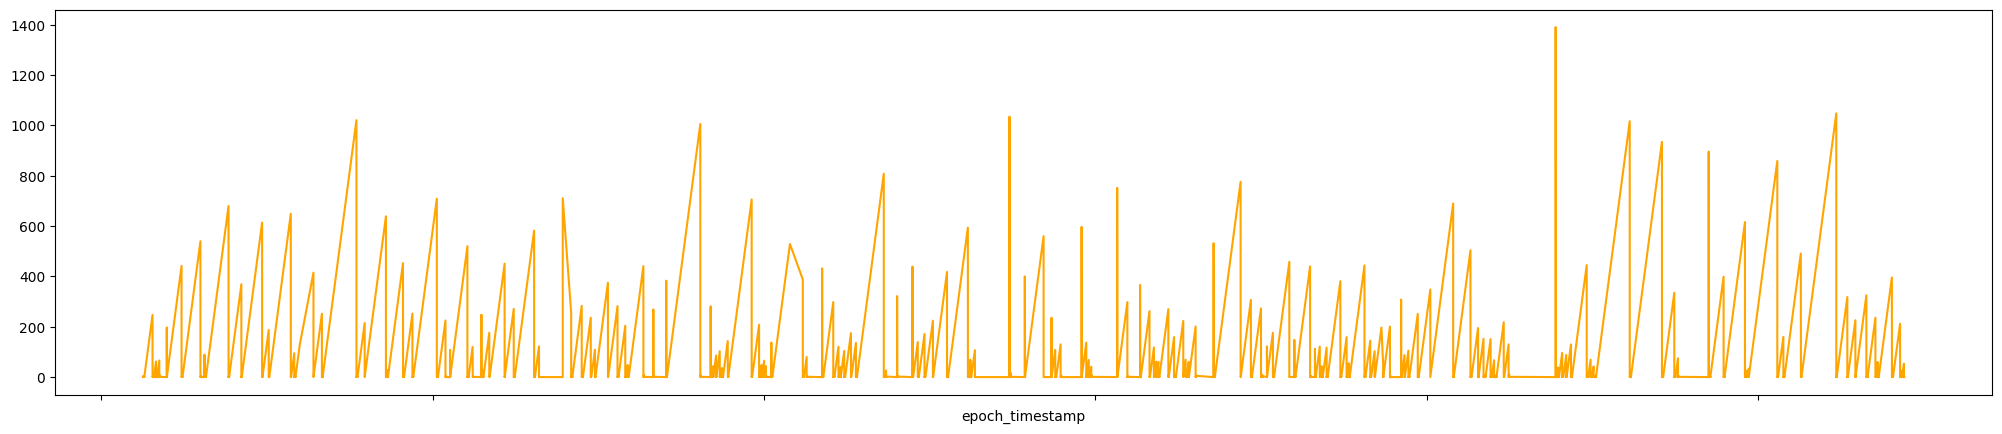

In [43]:
df.loc[(df['src_ip'] == '10.0.0.6') & (df['dest_ip'] == \
    '208.80.154.224')].\
        sort_values(by=['epoch_timestamp'], ascending=True).\
            set_index('epoch_timestamp')['time_diff_sec'].\
                plot(figsize=[25,5], kind='line', color='orange')\
                    .set(xticklabels=[])

#### Listing 6.48 Jupyter notebook code – Distribution of the time difference between connections

<Axes: >

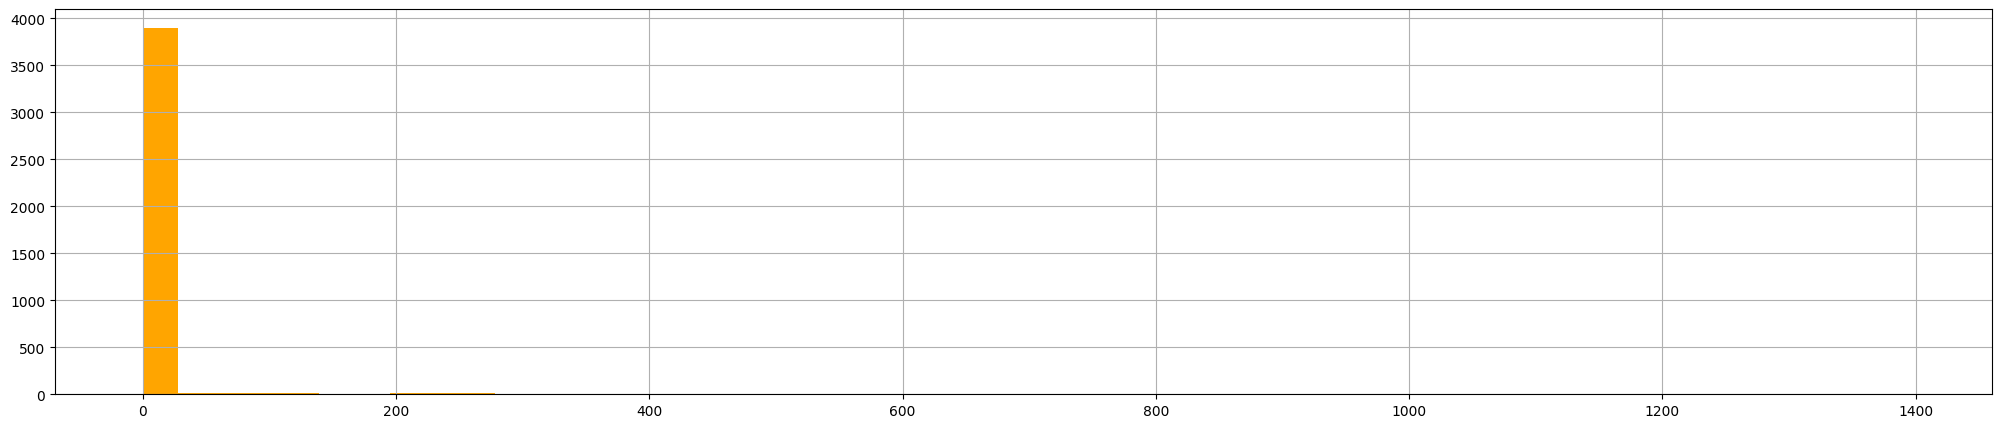

In [46]:
df.loc[(df['src_ip'] == '10.0.0.6') & (df['dest_ip'] \
    == '208.80.154.224') \
        ].sort_values(by=['epoch_timestamp'], \
            ascending=True).set_index('epoch_timestamp')['time_diff_sec'].\
                hist(figsize=[25,5], color='orange', bins=50)